<a href="https://colab.research.google.com/github/Paradise151/Time-series-forecasting/blob/main/FTS_naive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

In [2]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [3]:
from statsmodels.tsa.stattools import adfuller

In [4]:
import math

Прогноз трафика в википедии \

https://www.kaggle.com/c/web-traffic-time-series-forecasting

загрузите датасет на свой гугл диск \
обратитесь к нему для чтения датасета


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
df=pd.read_csv('gdrive/My Drive/train_2.csv')
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 804 entries, Page to 2017-09-10
dtypes: float64(803), object(1)
memory usage: 889.8+ MB


In [8]:
df.loc[7011]

Page          Thanksgiving_fr.wikipedia.org_desktop_all-agents
2015-07-01                                               102.0
2015-07-02                                               109.0
2015-07-03                                               101.0
2015-07-04                                               138.0
                                    ...                       
2017-09-06                                                68.0
2017-09-07                                                76.0
2017-09-08                                                82.0
2017-09-09                                                95.0
2017-09-10                                                92.0
Name: 7011, Length: 804, dtype: object

#Основная часть

In [10]:
data_start_date_train = '2015-07-01'
data_end_date_train = '2016-12-31'
data_start_date_test = '2017-01-01'
data_end_date_test = '2017-01-07'

In [11]:
df2train = df.loc[[86, 7011, 16332, 38103, 38386, 38883, 73107],data_start_date_train:data_end_date_train]
df2test = df.loc[[86, 7011, 16332, 38103, 38386, 38883, 73107],data_start_date_test:data_end_date_test]

In [12]:
df2 =  df.loc[[86, 7011, 16332, 38103, 38386, 38883, 73107],data_start_date_train:data_end_date_test]
df2T = df2.T

In [13]:
data_for_train = df.columns[(df.columns >= data_start_date_train) & (df.columns <= data_end_date_train)].tolist()
data_for_test = df.columns[ (df.columns > data_end_date_train) & (df.columns <= data_end_date_test)].tolist()

In [14]:
np.arange(1, 558, 76)     # для дальнейшей разметки оси OX

array([  1,  77, 153, 229, 305, 381, 457, 533])

# Функция для поиска средней погрешности

In [15]:
def mape(y_true, y_pred):          # функция для поиска средней погрешности
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Методы на основе периодограмм

In [16]:
from scipy.signal import periodogram

In [17]:
def myperiodogram(data):
    freq, power = periodogram(data)
    period = 1/freq[np.argmax(power)]
    # print(f"The period of the time series is {period}")

    plt.figure(figsize=(14, 7))
    plt.plot(freq, power)
    plt.title("Periodogram")
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power spectral density')
    print("Частота, соответствующая сезонности равна", freq[np.argmax(power)])

## Анализ Фурье


In [18]:
from scipy.fft import fft

In [19]:
def season_find(dataseries):
    yf = np.fft.fft(dataseries)
    xf = np.linspace(0.0, 1.0/(2.0), len(dataseries)//2)

    idx = np.argmax(np.abs(yf[1:len(dataseries)//2]))
    freq = xf[idx]

    period =(1/freq)
    myperiodogram(dataseries)
    if period != math.inf:
      print(f"Период сезоннной компоненты равен {period}")
      return round(period)
    else:
      print(f"Период сезоннной компоненты равен {period}")
      return len(df2train.columns)*5   #мистер костыль

# Основная прога

In [20]:
df2test.T   # типо транспонировалась

,86,7011,16332,38103,38386,38883,73107
2017-01-01,22.0,150.0,1493.0,41060.0,19509.0,11817.0,8619.0
2017-01-02,17.0,313.0,1743.0,34895.0,22443.0,12955.0,7795.0
2017-01-03,20.0,186.0,1558.0,26116.0,23483.0,13237.0,6680.0
2017-01-04,17.0,211.0,1704.0,22736.0,27431.0,12220.0,5127.0
2017-01-05,26.0,157.0,1596.0,21714.0,26781.0,12399.0,6468.0
2017-01-06,18.0,129.0,2023.0,19171.0,23234.0,12307.0,7159.0
2017-01-07,66.0,138.0,2220.0,21564.0,25445.0,14335.0,7573.0


In [25]:
def analysis(index, lag1, lag2):
    print(df.loc[index], '\n')

#наивные прогнозы
    #1 прогноз средним {
    historical_mean = np.mean(df2train.loc[index])
    print("Среднее значение временного ряда (для прогноза средним)", historical_mean)

    df2testT = df2test.T
    df2testT.loc[:, 'pred_mean'] =  historical_mean

    mape_mean = mape(df2testT[index], df2testT['pred_mean'])
    print("Погрешность метода усреднения", mape_mean)

    print("\n")  # переход на новую строку
    #2 наивный прогноз {
    last = df2train.loc[index][-1]
    print("Последнее значение врменного ряда", last)

    df2testT.loc[:, 'pred_naive'] =  last

    mape_naive = mape(df2testT[index], df2testT['pred_naive'])
    print("Погрешность наивного метода", mape_naive)


    print("\n")  # переход на новую строку

    #3 наивный сезонный прогноз по последнему сезону {}
    a = season_find(df2T[index])
    if a < len(df2train.columns):
        season_period = a
        season_pred = []

        for i  in range(0, len(df2test), 1):
            season_pred.append(df2.loc[index][len(data_for_train)  + i - season_period*(1+(i+1)//season_period)])

        df2testT.loc[:, 'pred_season'] =  season_pred

        mape_season = mape(df2testT[index], df2testT['pred_season'])

        print("Погрешность сезонного метода", mape_season)
        print(df2testT[["pred_mean", "pred_naive", "pred_season"]])
        print("\n") # переход на новую строку
        print(df2testT[index])


        # графики временного ряда - Train, Test, Prediction [
        plt.figure(figsize=(18,6))
        plt.title(f"Naive prediction \n error = {round(mape_naive,2)}")
        plt.plot( data_for_train ,df2train.loc[index].tolist(), label = 'TRAIN')
        plt.plot( data_for_test , df2test.loc[index].tolist(), label = "TEST", color = "orange")
        plt.plot(data_for_test, df2testT.loc[:, 'pred_mean'].tolist(), label = "Mean prediction", color = "red")  # прогноз средним
        plt.plot(data_for_test, df2testT.loc[:, 'pred_naive'].tolist(), label = "Naive prediction", color = "black")  # наивный прогноз
        plt.plot(data_for_test, df2testT.loc[:, 'pred_season'].tolist(), 'r--', label = "Last season prediction", color = "black")  # сезонный прогноз (по последнему)
        plt.xticks([  1,  77, 153, 229, 305, 381, 457, 533, 554])   # plt.xticks(range(1, 558, 70))
        plt.legend()
        # ]
    # }}}

    else:
          print(df2testT[["pred_mean", "pred_naive"]])
          print("\n") # переход на новую строку
          print(df2testT[index])

          # графики временного ряда - Train, Test, Prediction [
          plt.figure(figsize=(18,6))
          plt.title(f"Naive prediction \n error = {round(mape_naive,2)}")
          plt.plot( data_for_train ,df2train.loc[index].tolist(), label = 'TRAIN')
          plt.plot( data_for_test , df2test.loc[index].tolist(), label = "TEST", color = "orange")
          plt.plot(data_for_test, df2testT.loc[:, 'pred_mean'].tolist(), label = "Mean prediction", color = "red")  # прогноз средним
          plt.plot(data_for_test, df2testT.loc[:, 'pred_naive'].tolist(), label = "Naive prediction", color = "black")  # наивный прогноз
          # plt.plot(data_for_test, df2testT.loc[:, 'pred_season'].tolist(), 'r--', label = "Last season prediction", color = "black")  # сезонный прогноз (по последнему)
          plt.xticks([  1,  77, 153, 229, 305, 381, 457, 533, 554])   # plt.xticks(range(1, 558, 70))
          plt.legend()
          # ]

    print("\n") # переход на новую строку
    # print(df2testT[f'{"index"}'])     #вывод таблицы погнозов  !! не получилось :((


    # графики автокорелляции (
    f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

    plot_acf(df.loc[index,data_start_date_train:data_end_date_train],lags= lag1, ax=ax[0])
    plot_pacf(df.loc[index,data_start_date_train:data_end_date_train],lags=lag2, ax=ax[1])
    plt.xticks(range(0, lag2, 5))
    plt.show()
    # )


    # # Проведем тест Дики-Фуллера на стационарность
    # result = adfuller(df2train.loc[index])

    # print('ADF Statistic: %f' % result[0])
    # print('p-value: %f' % result[1])
    # print('Critical Values:')
    # for key, value in result[4].items():
    #     print('\t%s: %.3f' % (key, value))

    # if result[1] > result[4]['5%']:
    #   print("Временной ряд нестационарен! Тест Дики-Фуллера")
    # else:
    #    print("Временной ряд стационарен! Тест Дики-Фуллера")


строки с номерами 86, 7011, 16332, 38103, 38386, 38883, 73107

In [22]:
mass_index = [86, 7011, 16332, 38103, 38386, 38883, 73107]

Page          Lady_Gaga_zh.wikipedia.org_all-access_spider
2015-07-01                                             9.0
2015-07-02                                             4.0
2015-07-03                                             9.0
2015-07-04                                            11.0
                                  ...                     
2017-09-06                                            36.0
2017-09-07                                            24.0
2017-09-08                                            36.0
2017-09-09                                            12.0
2017-09-10                                            13.0
Name: 86, Length: 804, dtype: object 

Среднее значение временного ряда (для прогноза средним) 16.69090909090909
Погрешность метода усреднения 23.157388066478976


Последнее значение врменного ряда 16.0
Погрешность наивного метода 26.33823692647222


Частота, соответствующая сезонности равна 0.0017953321364452424
Период сезоннной компоненты равен in

<ipython-input-19-261873a13b99>:8: RuntimeWarning: divide by zero encountered in scalar divide
  period =(1/freq)


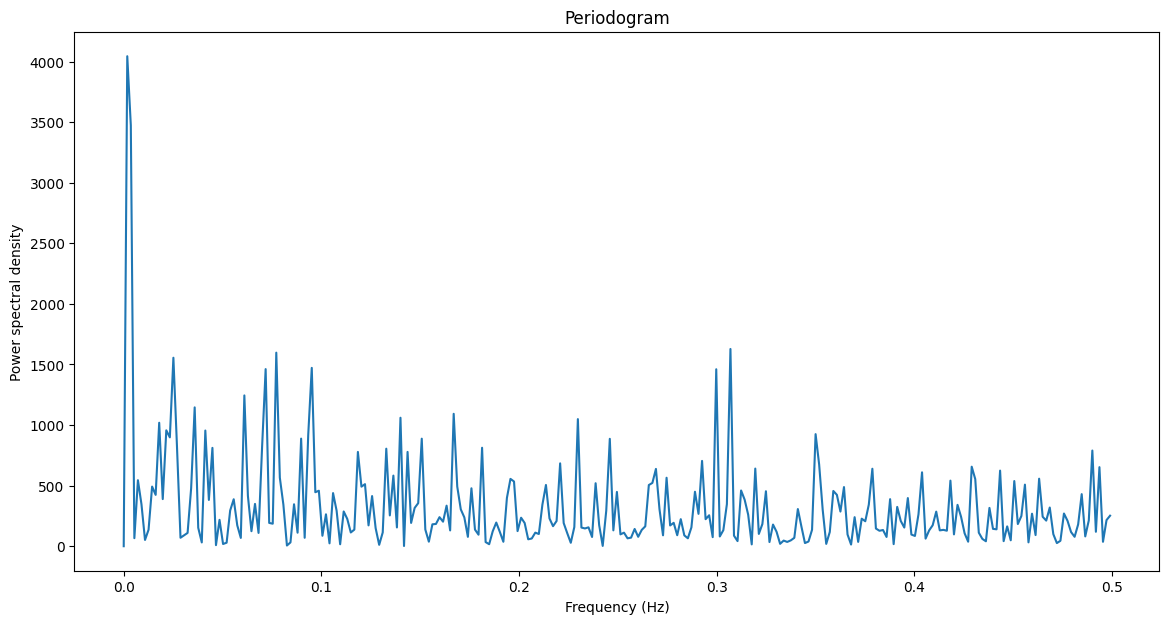

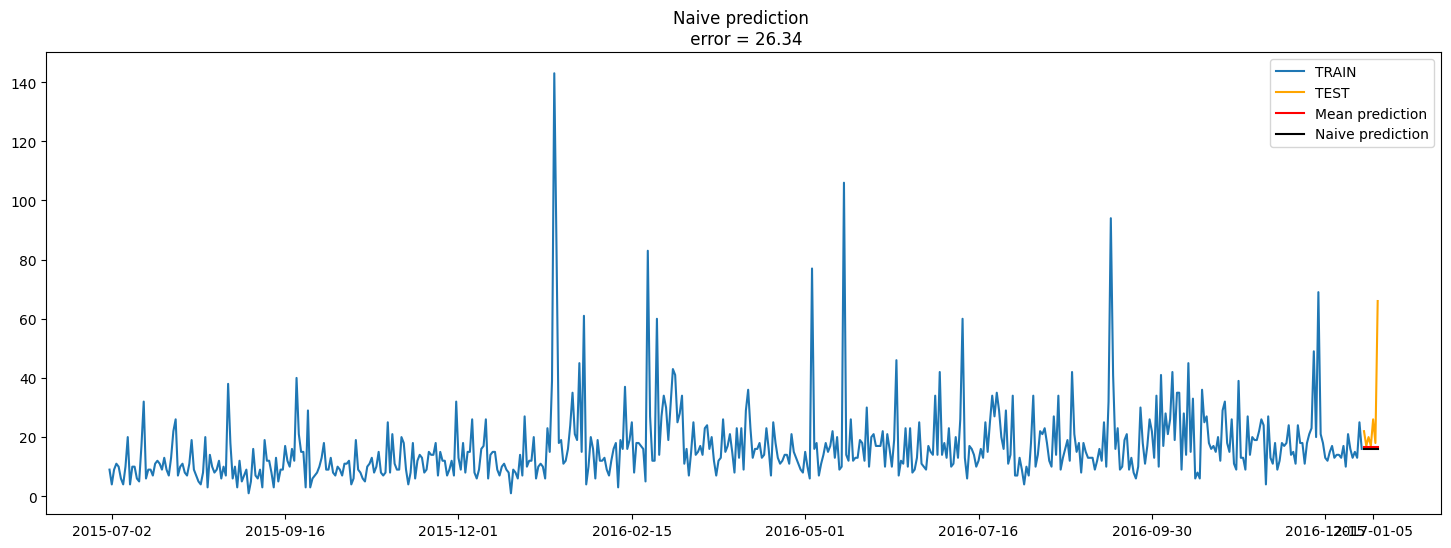

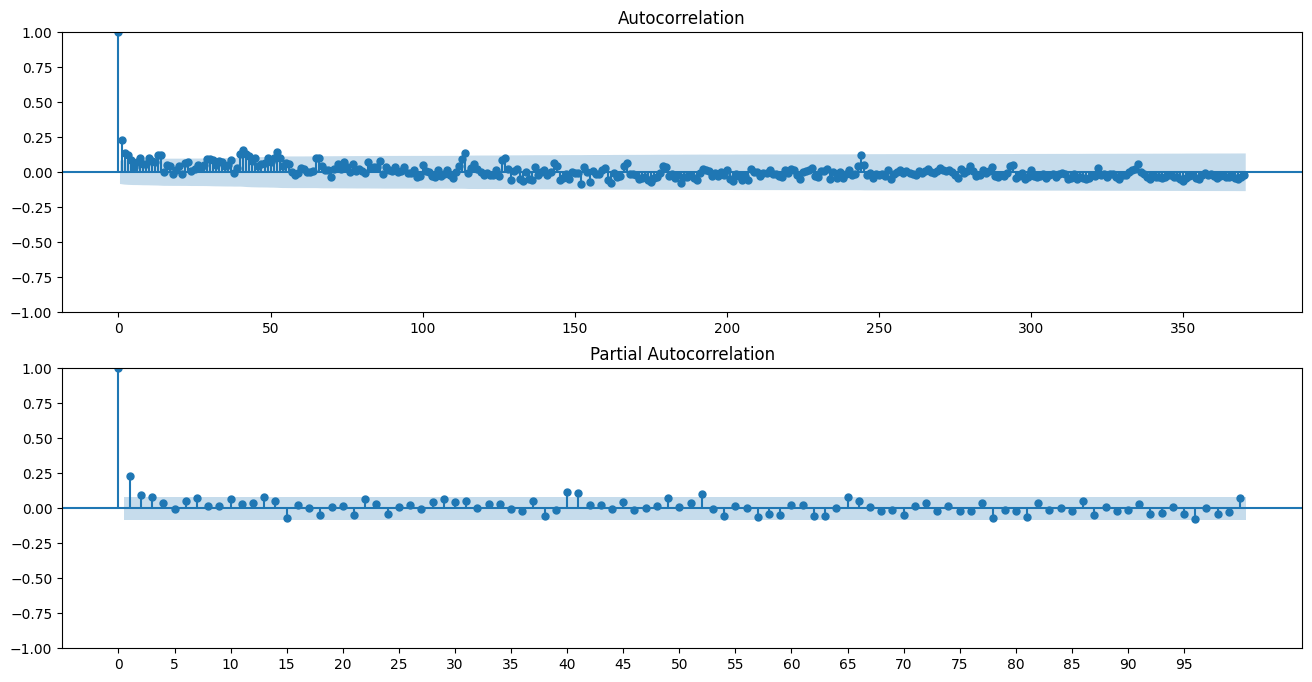





---------------------------------------


Page          Thanksgiving_fr.wikipedia.org_desktop_all-agents
2015-07-01                                               102.0
2015-07-02                                               109.0
2015-07-03                                               101.0
2015-07-04                                               138.0
                                    ...                       
2017-09-06                                                68.0
2017-09-07                                                76.0
2017-09-08                                                82.0
2017-09-09                                                95.0
2017-09-10                                                92.0
Name: 7011, Length: 804, dtype: object 

Среднее значение временного ряда (для прогноза средним) 451.34
Погрешность метода усреднения 166.5805986660247


Последнее значение врменного ряда 125.0
Погрешность наивного метода 26.16968397825788


Частота, соответств

<ipython-input-25-92cca9182e5a>:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(data_for_test, df2testT.loc[:, 'pred_season'].tolist(), 'r--', label = "Last season prediction", color = "black")  # сезонный прогноз (по последнему)


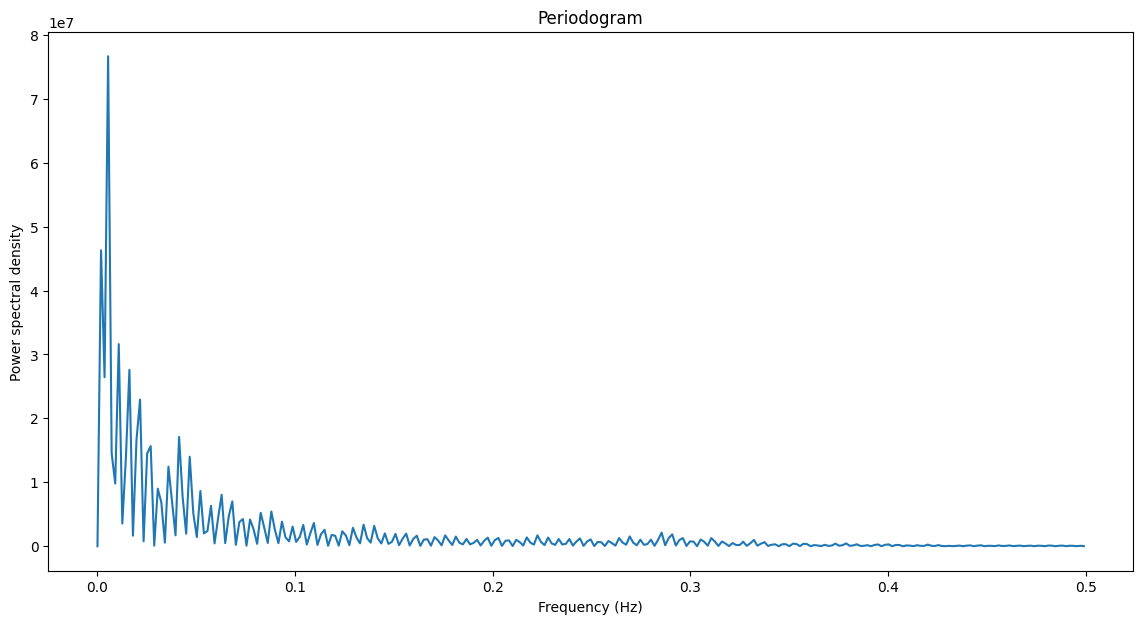

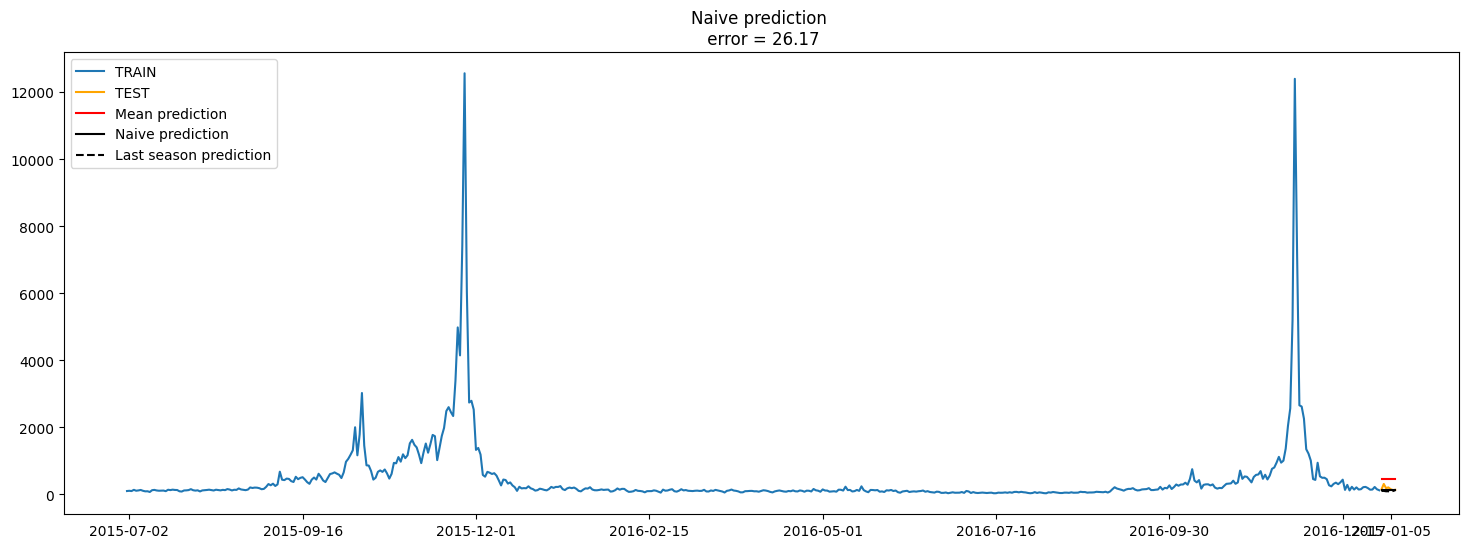

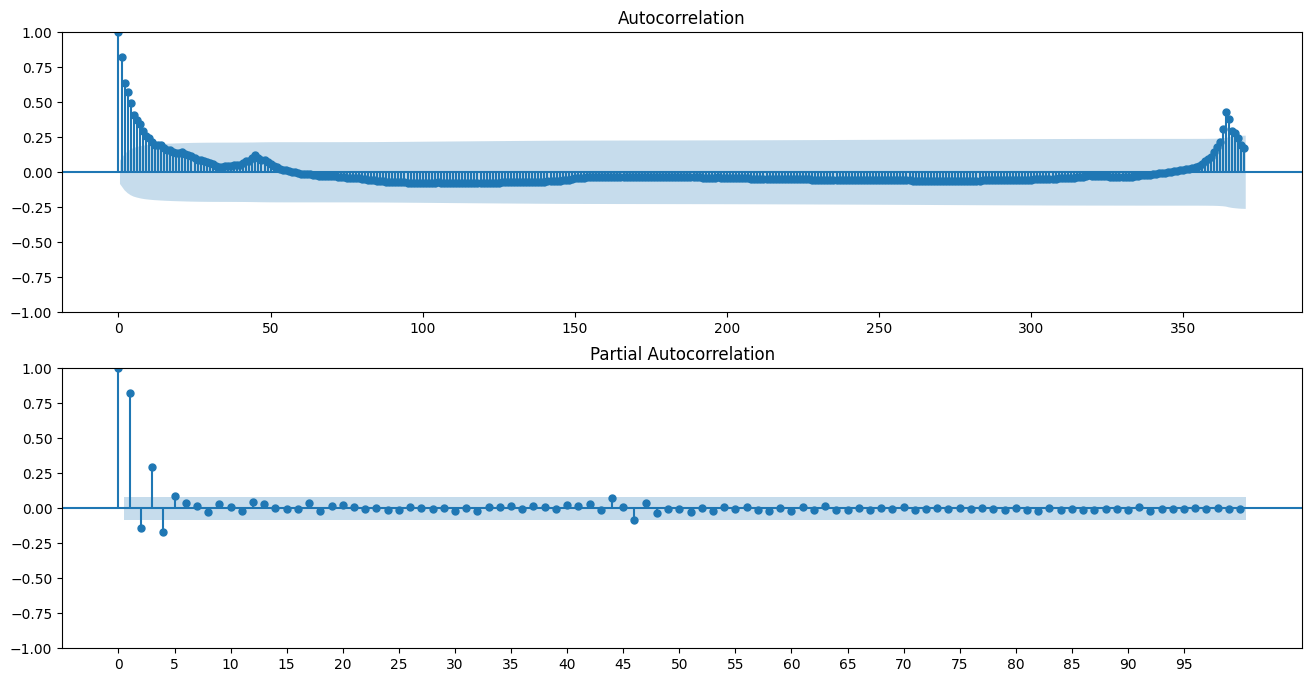





---------------------------------------


Page          Глинтвейн_ru.wikipedia.org_mobile-web_all-agents
2015-07-01                                                79.0
2015-07-02                                                91.0
2015-07-03                                                96.0
2015-07-04                                               117.0
                                    ...                       
2017-09-06                                               274.0
2017-09-07                                               292.0
2017-09-08                                               303.0
2017-09-09                                               438.0
2017-09-10                                               328.0
Name: 16332, Length: 804, dtype: object 

Среднее значение временного ряда (для прогноза средним) 393.78727272727275
Погрешность метода усреднения 77.2528722661111


Последнее значение врменного ряда 1791.0
Погрешность наивного метода 12.254982227602508


Часто

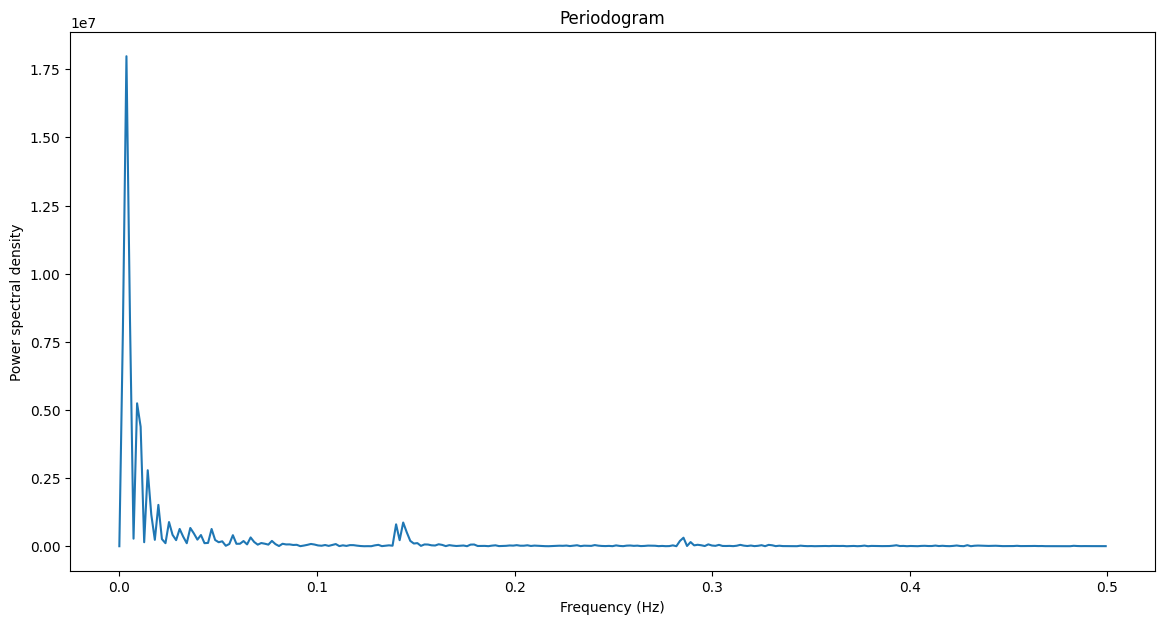

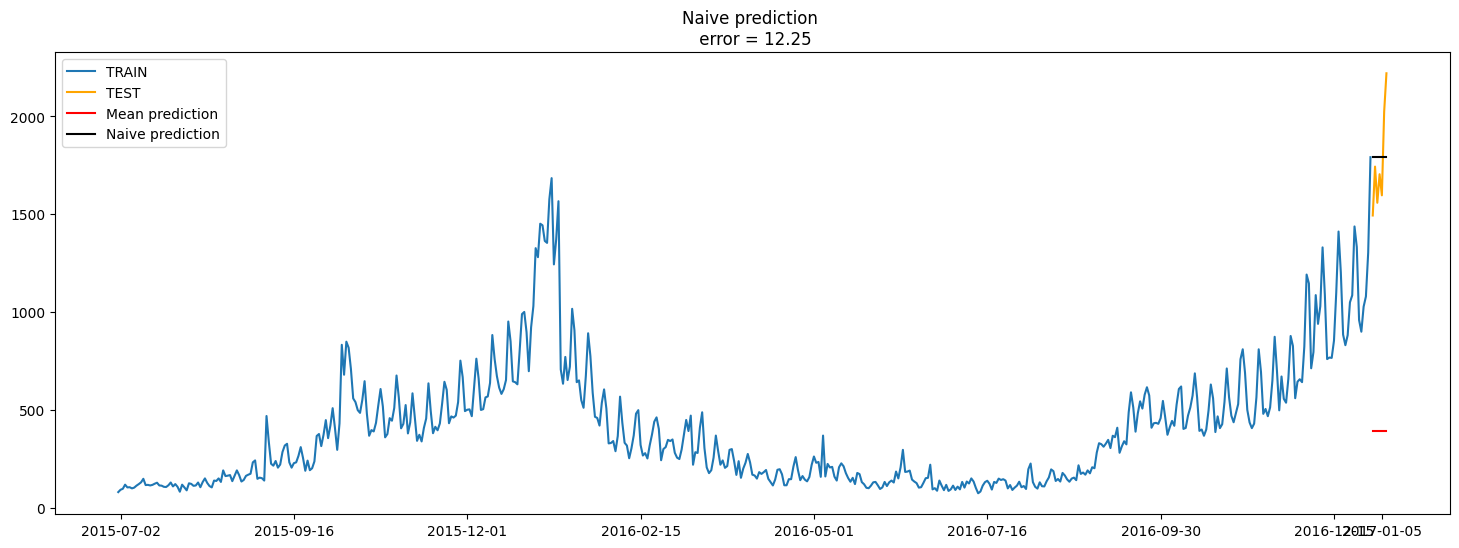

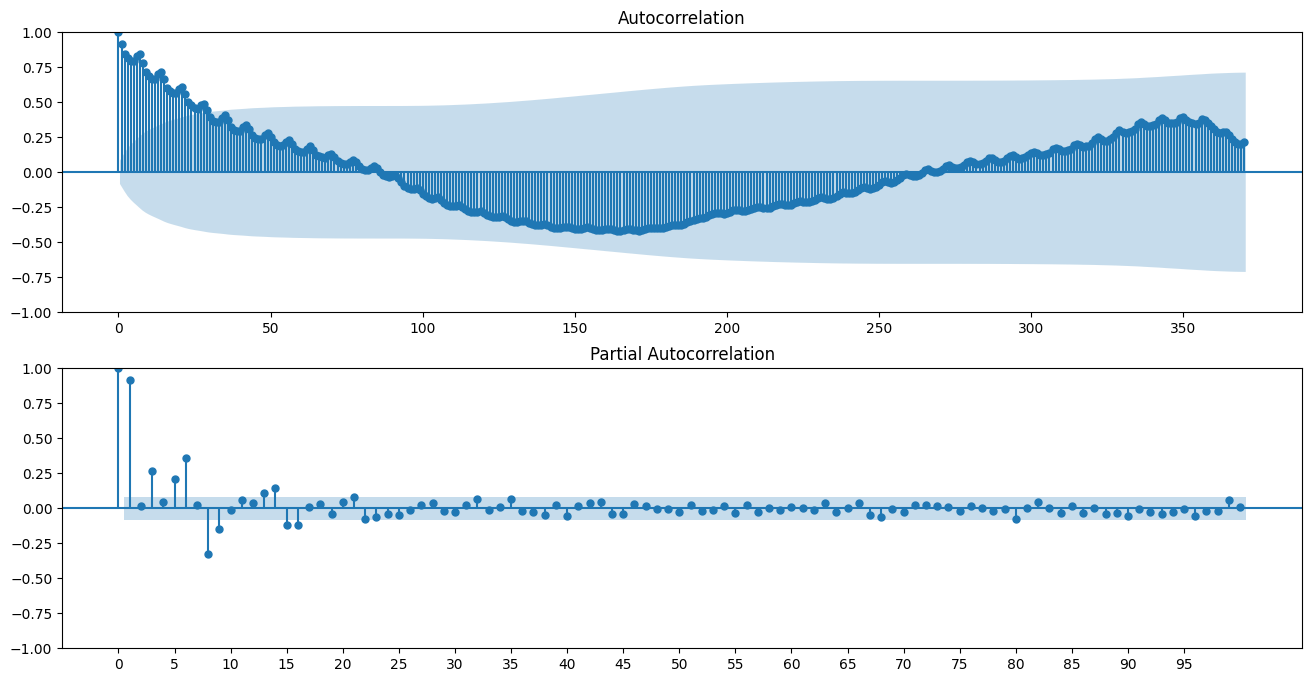





---------------------------------------


Page          Harry_Potter_en.wikipedia.org_all-access_all-a...
2015-07-01                                              16985.0
2015-07-02                                              16748.0
2015-07-03                                              16871.0
2015-07-04                                              25168.0
                                    ...                        
2017-09-06                                              14388.0
2017-09-07                                              13814.0
2017-09-08                                              12839.0
2017-09-09                                              13629.0
2017-09-10                                              15163.0
Name: 38103, Length: 804, dtype: object 

Среднее значение временного ряда (для прогноза средним) 19422.21818181818
Погрешность метода усреднения 22.720278391936652


Последнее значение врменного ряда 32835.0
Погрешность наивного метода 38.6912780822

<ipython-input-25-92cca9182e5a>:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(data_for_test, df2testT.loc[:, 'pred_season'].tolist(), 'r--', label = "Last season prediction", color = "black")  # сезонный прогноз (по последнему)


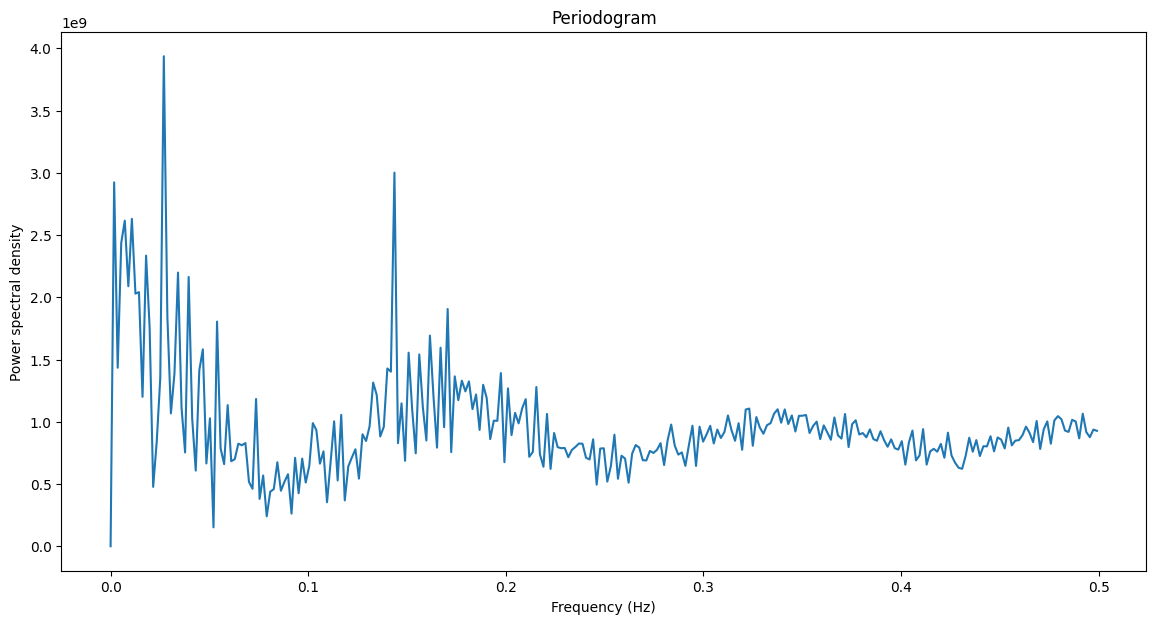

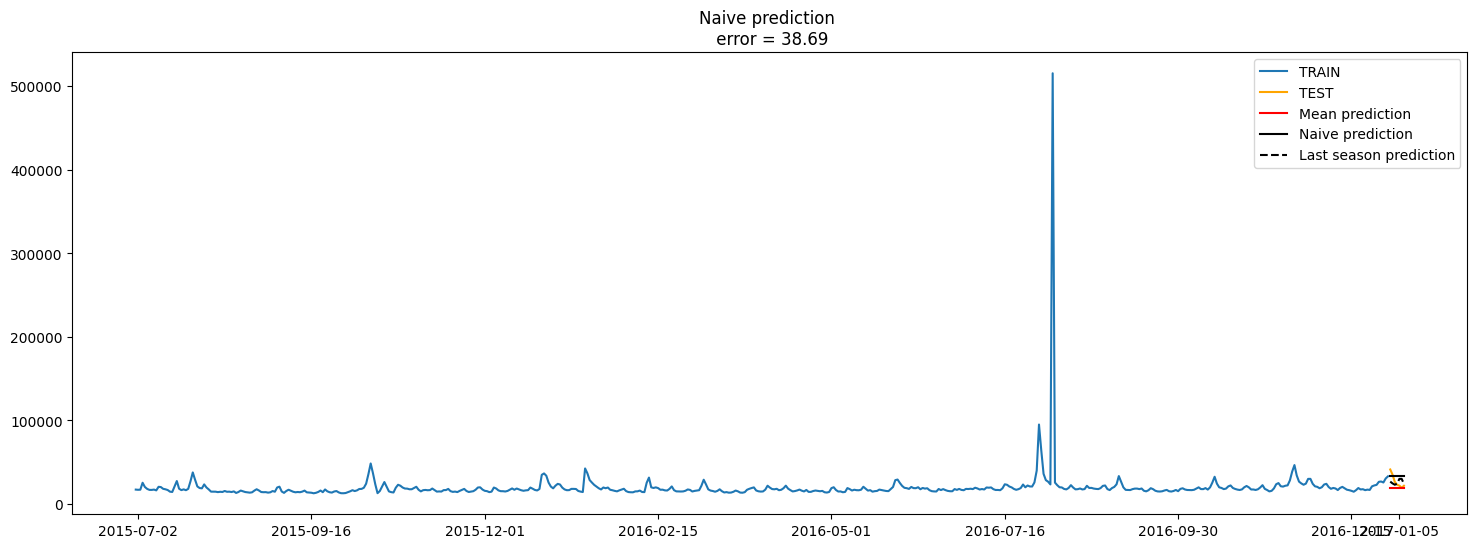

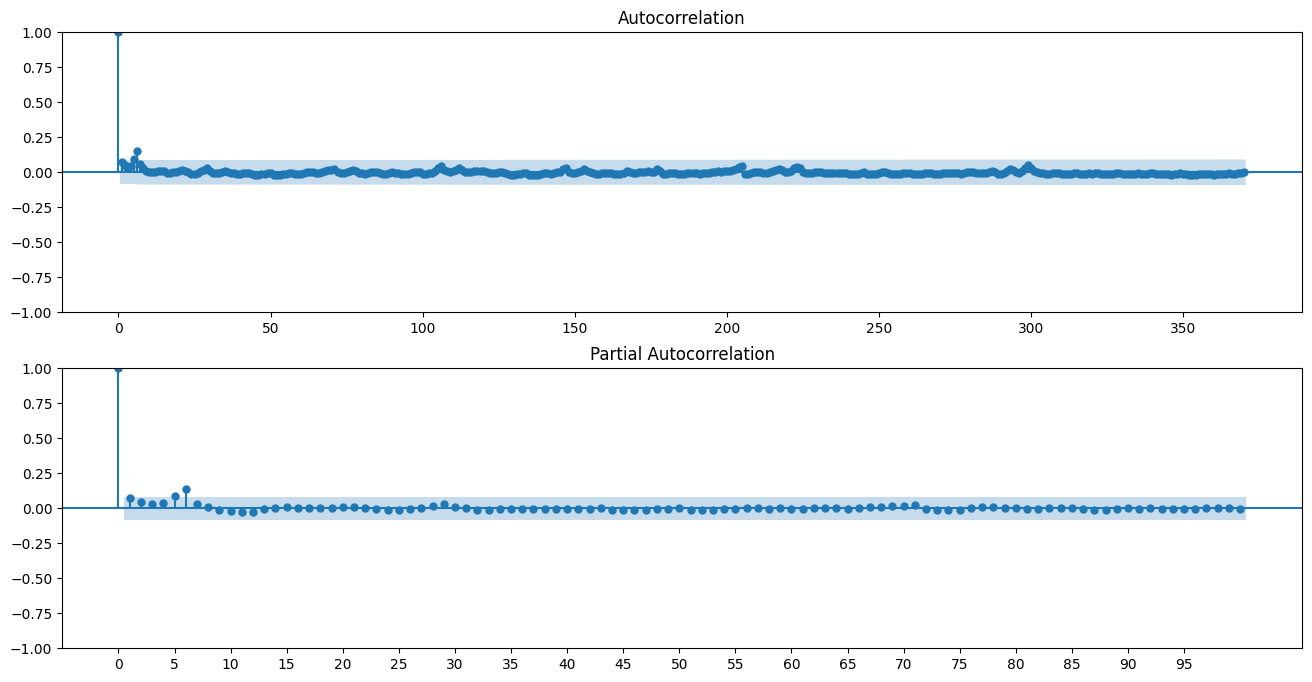





---------------------------------------


Page          Kim_Kardashian_en.wikipedia.org_all-access_all...
2015-07-01                                              28688.0
2015-07-02                                              23708.0
2015-07-03                                              21744.0
2015-07-04                                              20821.0
                                    ...                        
2017-09-06                                              20400.0
2017-09-07                                              24249.0
2017-09-08                                              17280.0
2017-09-09                                              15987.0
2017-09-10                                                  NaN
Name: 38386, Length: 804, dtype: object 

Среднее значение временного ряда (для прогноза средним) 24112.376363636362
Погрешность метода усреднения 9.256446646391966


Последнее значение врменного ряда 19199.0
Погрешность наивного метода 19.2173144821

<ipython-input-25-92cca9182e5a>:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(data_for_test, df2testT.loc[:, 'pred_season'].tolist(), 'r--', label = "Last season prediction", color = "black")  # сезонный прогноз (по последнему)


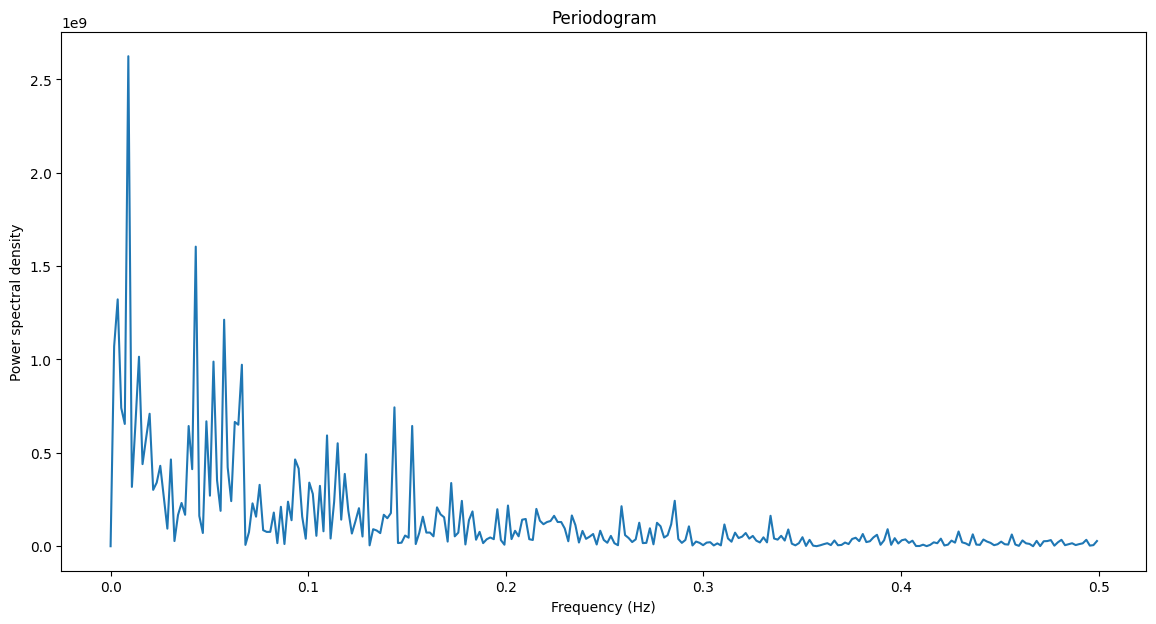

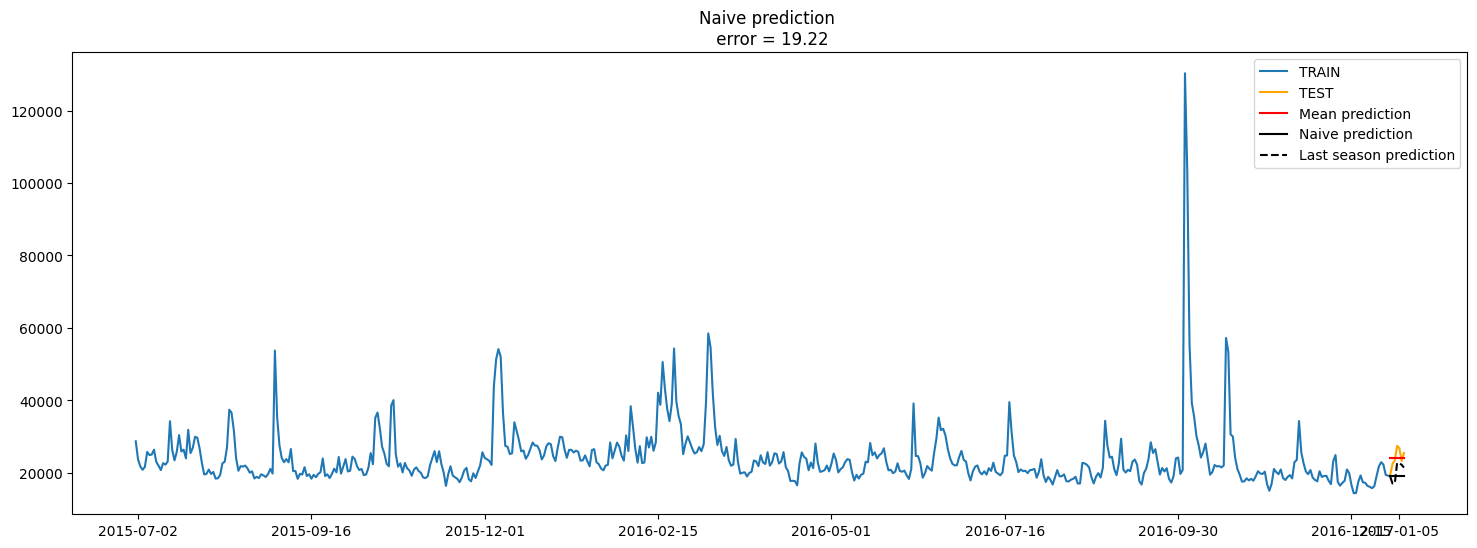

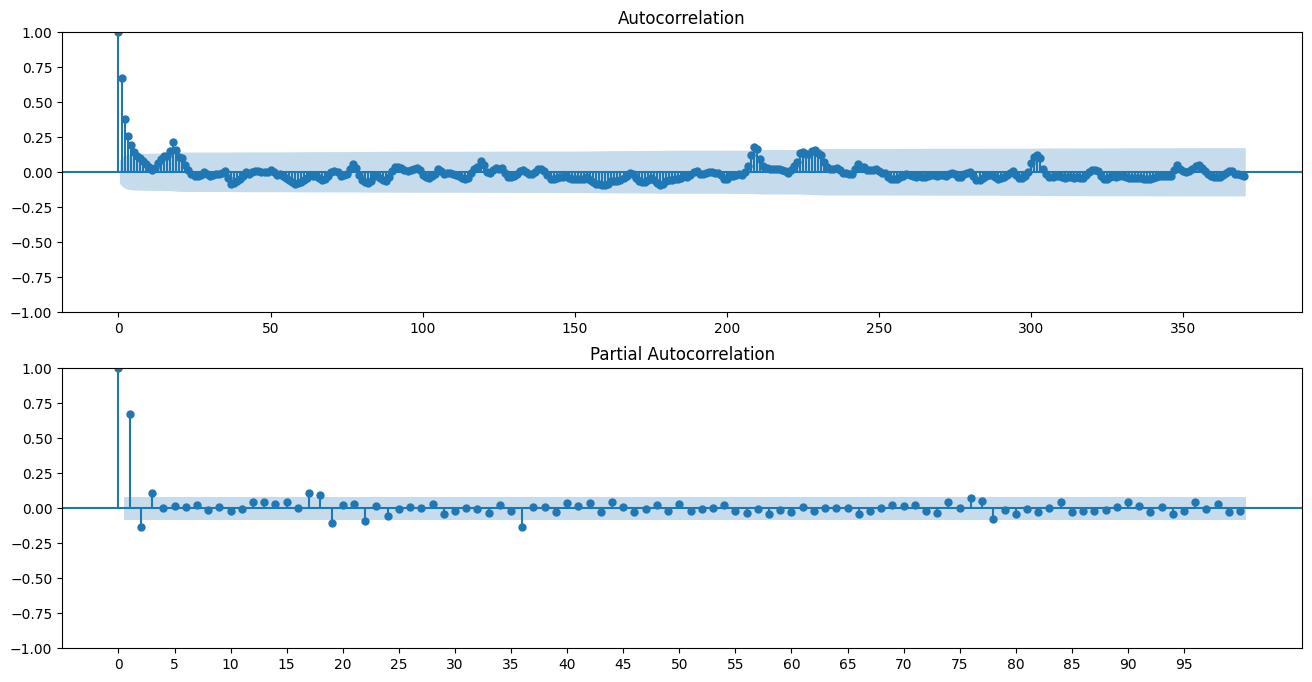





---------------------------------------


Page          Pornhub_en.wikipedia.org_all-access_all-agents
2015-07-01                                           11772.0
2015-07-02                                           12435.0
2015-07-03                                           12017.0
2015-07-04                                           12043.0
                                   ...                      
2017-09-06                                           17962.0
2017-09-07                                           17623.0
2017-09-08                                           17736.0
2017-09-09                                           17853.0
2017-09-10                                           17642.0
Name: 38883, Length: 804, dtype: object 

Среднее значение временного ряда (для прогноза средним) 13386.065454545454
Погрешность метода усреднения 7.231755765727968


Последнее значение врменного ряда 10507.0
Погрешность наивного метода 17.316129174672007


Частота, соответствующая 

<ipython-input-25-92cca9182e5a>:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(data_for_test, df2testT.loc[:, 'pred_season'].tolist(), 'r--', label = "Last season prediction", color = "black")  # сезонный прогноз (по последнему)


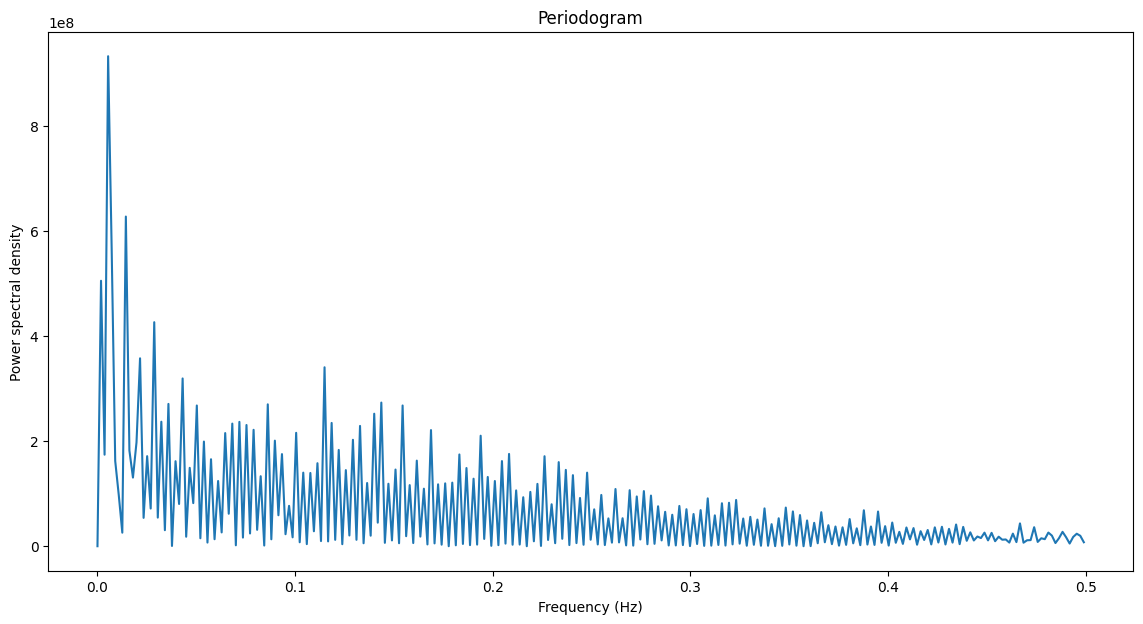

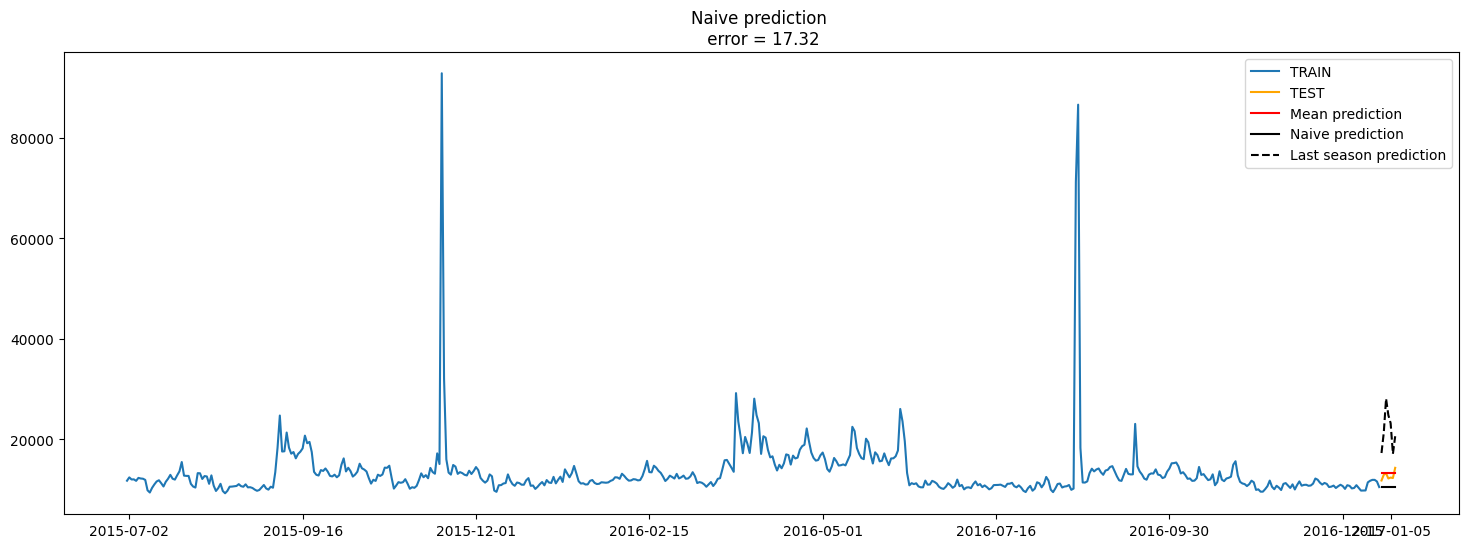

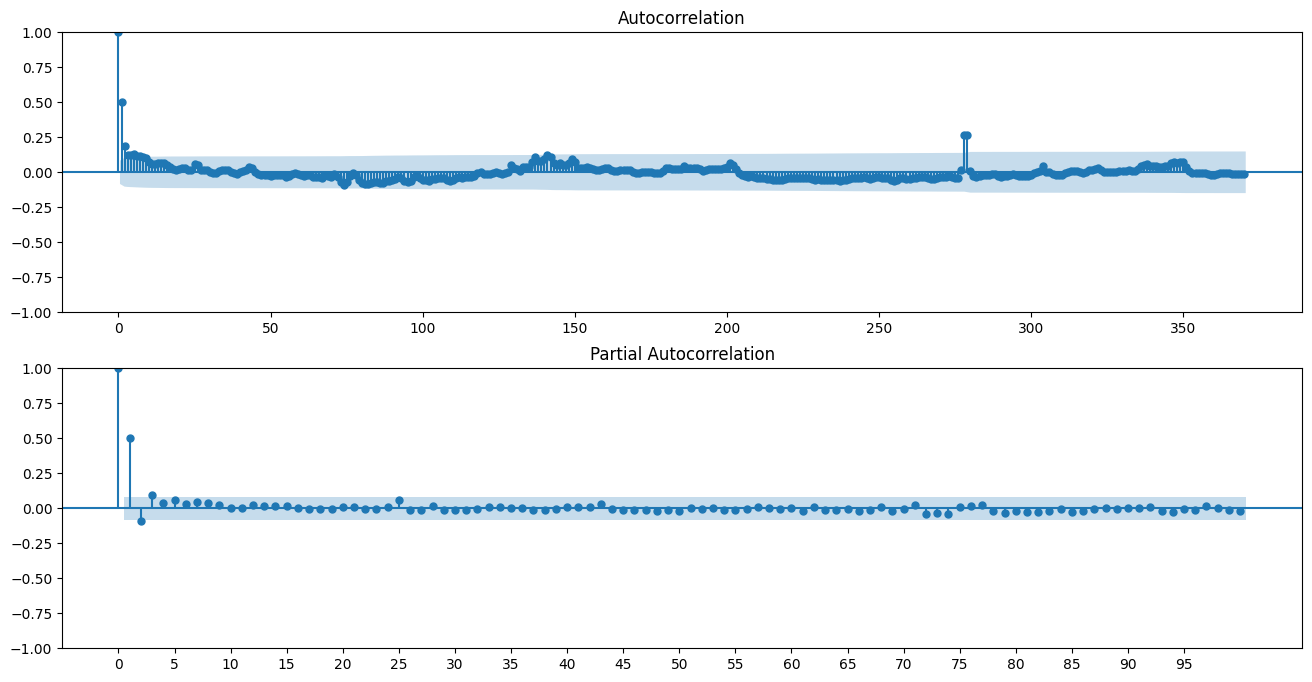





---------------------------------------


Page          Bruce_Willis_en.wikipedia.org_mobile-web_all-a...
2015-07-01                                               4984.0
2015-07-02                                               4549.0
2015-07-03                                               5330.0
2015-07-04                                               7457.0
                                    ...                        
2017-09-06                                               3388.0
2017-09-07                                               3370.0
2017-09-08                                               3971.0
2017-09-09                                               5513.0
2017-09-10                                               5417.0
Name: 73107, Length: 804, dtype: object 

Среднее значение временного ряда (для прогноза средним) 4624.367272727272
Погрешность метода усреднения 32.92049962667233


Последнее значение врменного ряда 8440.0
Погрешность наивного метода 23.021145669200

<ipython-input-25-92cca9182e5a>:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(data_for_test, df2testT.loc[:, 'pred_season'].tolist(), 'r--', label = "Last season prediction", color = "black")  # сезонный прогноз (по последнему)


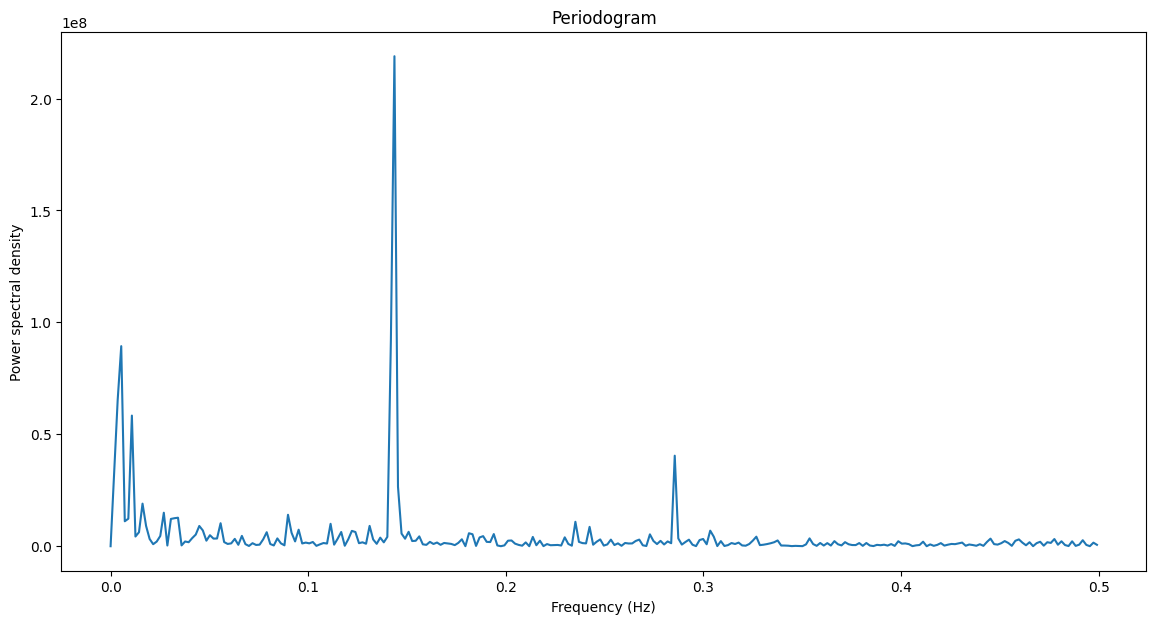

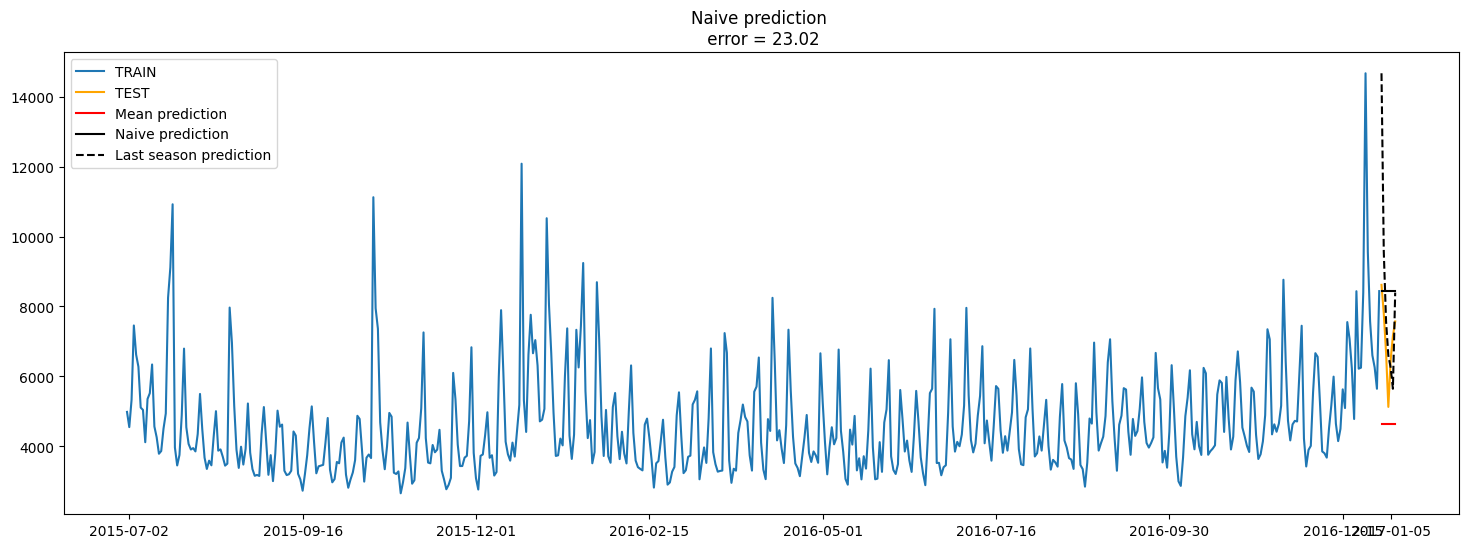

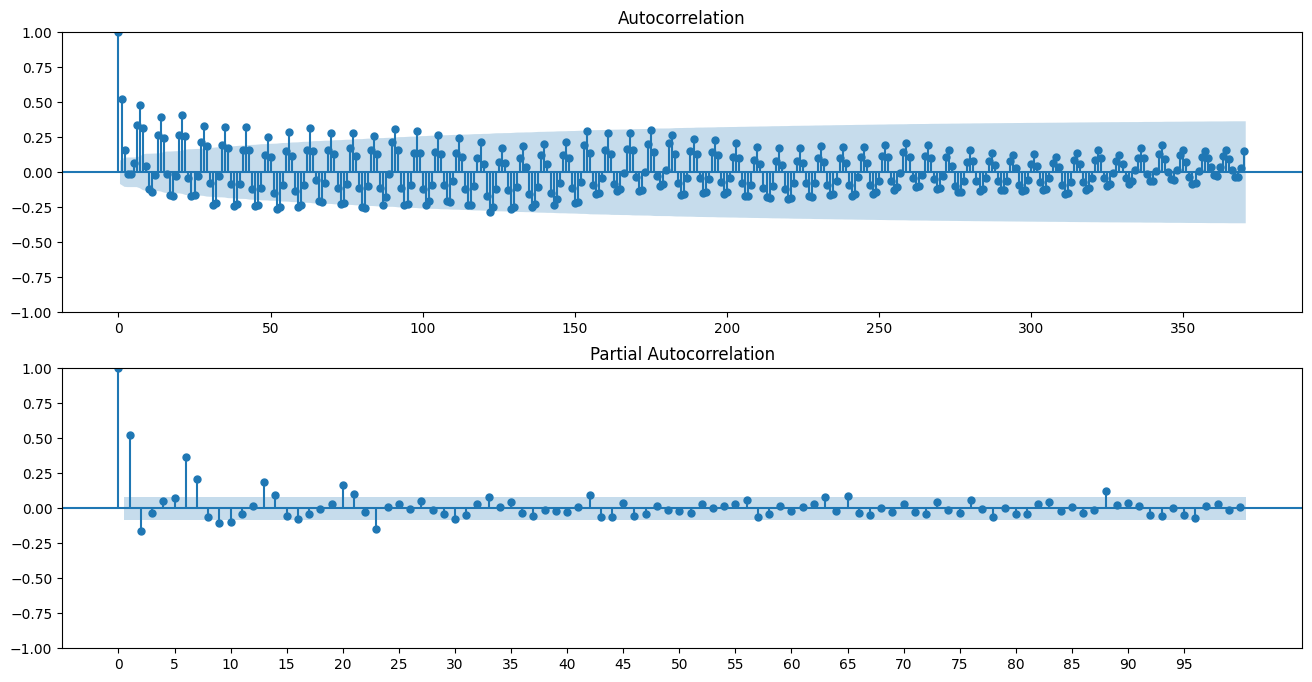





---------------------------------------




In [26]:
for i in range(len(mass_index)):
  analysis(mass_index[i], 370, 100)
  print("\n")
  print("\n")
  print("---------------------------------------")
  print("\n")

# Проверка на отсутствие пропущенных дат

Теперь давайте проверим, не пропущены ли какие-либо даты в нашем временном ряду.

In [27]:
start_date = df2.T.index.min()
end_date = df2.T.index.max()

date_range = pd.date_range(start=start_date, end=end_date, freq='D')

missing_dates = date_range[~date_range.isin(df2.T.index)]

if len(missing_dates) > 0:
    print("Missing dates:", missing_dates)
else:
    print("No missing dates")


No missing dates
